[Tham khao](https://towardsdatascience.com/a-guide-to-exploit-random-forest-classifier-in-pyspark-46d6999cb5db)

## 1. Import Data

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ML-RandomForest').getOrCreate()
df = spark.read.csv('Dataset/train.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: integer (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Previously_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)



In [2]:
df.show(10)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|
|  4|  Male| 21|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|    203|  

In [ ]:
#count distinct value of all columns
from pyspark.sql.functions import countDistinct
df.select([countDistinct(c).alias(c) for c in df.columns]).show()

## Dont run this section - Draft Section

In [4]:
numerical_columns = ['Age', 'Region_Code', 'Annual_Premium', 'Vintage']
categorical_columns = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']

In [9]:
#MinMaxScaler on numerical columns
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = numerical_columns, outputCol = 'features')
output = assembler.transform(df)

scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaledFeatures')
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)

scaledData.show(10)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+--------------------+--------------------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|            features|      scaledFeatures|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+--------------------+--------------------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|[44.0,28.0,40454....|[0.36923076923076...|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|[76.0,3.0,33536.0...|[0.86153846153846...|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Y

In [11]:
#Split the data into train and test
train, test = scaledData.randomSplit([0.7, 0.3], seed = 123)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Response')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [13]:
predictions.show(25)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+--------------------+--------------------+--------------------+--------------------+----------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|[47.0,28.0,38294....|[0.41538461538461...|[17.4351914968468...|[0.87175957484234...|       0.0|
|  7|  Male| 23|              1|       11.0|

In [16]:
predictions.select("Response", "prediction").show(10)

+--------+----------+
|Response|prediction|
+--------+----------+
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows



In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Response", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8198065256599442
Test Error = 0.18019347434005584


In [18]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction','Response']).withColumn('Response', F.col('Response').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','Response'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[99950.     0.]
 [13993.     0.]]


## 2. New Section - Run this section

### 2.1. Split Vehicle_Age into 3 columns

In [3]:
# numerical_columns = ['Age', 'Region_Code', 'Annual_Premium', 'Vintage']
# categorical_columns = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']
input_cols = ['Age', 'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2', 'Previously_Insured', 'Vehicle_Damage']

In [ ]:
#convert Vehicle_Age to numerical
from pyspark.sql.functions import when

df = df.withColumn('Vehicle_Age_0', when(df['Vehicle_Age'] == '< 1 Year', 0.0).when(df['Vehicle_Age'] == '1-2 Year', 1.0).otherwise(2.0))

In [4]:
from pyspark.sql import functions as F
#new column Vehicle_Age_0 for Vehicle_Age < 1 Year
df = df.withColumn('Vehicle_Age_0', F.when(F.col('Vehicle_Age') == '< 1 Year', 1).otherwise(0))
#new column Vehicle_Age_1 for Vehicle_Age 1-2 Year
df = df.withColumn('Vehicle_Age_1', F.when(F.col('Vehicle_Age') == '1-2 Year', 1).otherwise(0))
#new column Vehicle_Age_2 for Vehicle_Age > 2 Years
df = df.withColumn('Vehicle_Age_2', F.when(F.col('Vehicle_Age') == '> 2 Years', 1).otherwise(0))
#drop Vehicle_Age column
df = df.drop('Vehicle_Age')
#Vehicle_Damage column to 0 and 1
df = df.withColumn('Vehicle_Damage', F.when(F.col('Vehicle_Damage') == 'Yes', 1).otherwise(0))
df.show(5)

+---+------+---+---------------+-----------+------------------+--------------+--------------+--------------------+-------+--------+-------------+-------------+-------------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Vehicle_Age_0|Vehicle_Age_1|Vehicle_Age_2|
+---+------+---+---------------+-----------+------------------+--------------+--------------+--------------------+-------+--------+-------------+-------------+-------------+
|  1|  Male| 44|              1|       28.0|                 0|             1|       40454.0|                26.0|    217|       1|            0|            0|            1|
|  2|  Male| 76|              1|        3.0|                 0|             0|       33536.0|                26.0|    183|       0|            0|            1|            0|
|  3|  Male| 47|              1|       28.0|                 0|             1|       38294.0|                26.0|     27|       1

### 2.2. Resampling Imbalanced Data

<AxesSubplot:xlabel='Response', ylabel='count'>

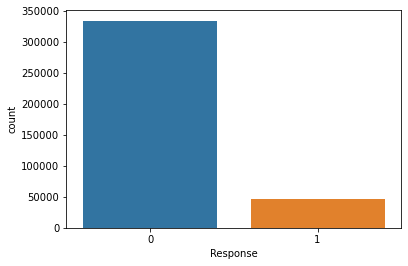

In [5]:
#EDA
import pandas as pd
df_EDA = df.toPandas()
#countplot for df_train['Response']
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.countplot(x='Response', data=df_EDA[['Response']])

#### Run Way 1 or Way 2

#### Way 1: Decrease the number of samples in the majority class

In [29]:
#data is imbalance, response = 0 is much more than response = 1, remove some rows of response = 0
df_EDA_balance = df_EDA[df_EDA['Response'] == 1]
df_EDA_balance = df_EDA_balance.append(df_EDA[df_EDA['Response'] == 0].sample(n=46710, random_state=123))


C:\Users\Admin\AppData\Local\Temp\ipykernel_56060\4125765123.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_EDA_balance = df_EDA_balance.append(df_EDA[df_EDA['Response'] == 0].sample(n=46710, random_state=123))


<AxesSubplot:xlabel='Response', ylabel='count'>

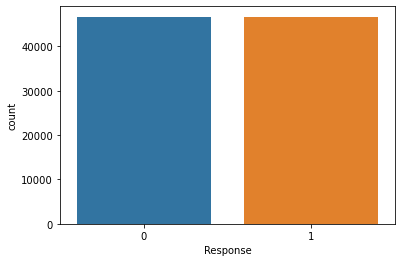

In [30]:
sns.countplot(x='Response', data=df_EDA_balance[['Response']])

#### Way 2: Increase the number of samples in the minority class

<AxesSubplot:xlabel='Response', ylabel='count'>

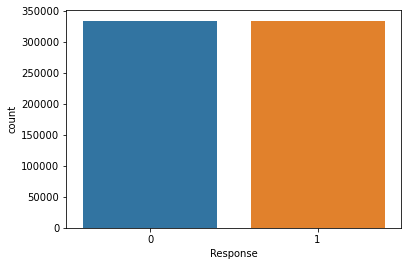

In [6]:
#data is imbalanced, so we need to balance it, resample dataset
from sklearn.utils import resample
df_majority = df_EDA[df_EDA['Response'] == 0]
df_minority = df_EDA[df_EDA['Response'] == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=334399, random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['Response'].value_counts()

sns.countplot(x='Response', data=df_upsampled[['Response']])

### 2.3. Vectorize - Skip Minmaxscaler

In [8]:
df = spark.createDataFrame(df_upsampled)
#MinMaxScaler on numerical columns
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = input_cols, outputCol = 'features')
output = assembler.transform(df)
output.show(10)

# scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaledFeatures')
# scalerModel = scaler.fit(output)
# scaledData = scalerModel.transform(output)

# scaledData.show(10)


+---+------+---+---------------+-----------+------------------+--------------+--------------+--------------------+-------+--------+-------------+-------------+-------------+--------------------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Vehicle_Age_0|Vehicle_Age_1|Vehicle_Age_2|            features|
+---+------+---+---------------+-----------+------------------+--------------+--------------+--------------------+-------+--------+-------------+-------------+-------------+--------------------+
|  2|  Male| 76|              1|        3.0|                 0|             0|       33536.0|                26.0|    183|       0|            0|            1|            0|(6,[0,2],[76.0,1.0])|
|  4|  Male| 21|              1|       11.0|                 1|             0|       28619.0|               152.0|    203|       0|            1|            0|            0|[21.0,1.0,0.0,0.0...|
|  5|Female| 29|         

In [9]:
#Split the data into train and test
train, test = output.randomSplit([0.7, 0.3], seed = 123)

### 2.4. Training Model Random Forest

In [10]:
#Random Forest
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Response')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

predictions.show(25)

predictions.select("Response", "prediction").show(10)

+---+------+---+---------------+-----------+------------------+--------------+--------------+--------------------+-------+--------+-------------+-------------+-------------+--------------------+--------------------+--------------------+----------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Vehicle_Age_0|Vehicle_Age_1|Vehicle_Age_2|            features|       rawPrediction|         probability|prediction|
+---+------+---+---------------+-----------+------------------+--------------+--------------+--------------------+-------+--------+-------------+-------------+-------------+--------------------+--------------------+--------------------+----------+
|  5|Female| 29|              1|       41.0|                 1|             0|       27496.0|               152.0|     39|       0|            1|            0|            0|[29.0,1.0,0.0,0.0...|[19.5333902086973...|[0.97666951043486...|       0.0|
| 10|Fem

In [11]:
#Validation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Response", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.7830395039637373
Test Error = 0.21696049603626266


In [12]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction','Response']).withColumn('Response', F.col('Response').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','Response'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

c:\Users\Admin\anaconda3\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[61334. 38564.]
 [ 3403. 96287.]]


### 2.5. Export Model - DONT RUN IT

In [13]:
rf.save('rf_model_K20411')

Py4JJavaError: An error occurred while calling o356.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.hadoop.mapred.FileOutputCommitter.setupJob(FileOutputCommitter.java:131)
	at org.apache.hadoop.mapred.OutputCommitter.setupJob(OutputCommitter.java:265)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:79)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1599)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1599)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1585)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1585)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.util.DefaultParamsWriter.saveImpl(ReadWrite.scala:384)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:577)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:343)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:344)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:901)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1046)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1055)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 22 more


In [36]:
#Export model
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])
pipelineModel = pipeline.fit(df)
pipelineModel.write().overwrite().save('rf_model')

Py4JJavaError: An error occurred while calling o1091.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.hadoop.mapred.FileOutputCommitter.setupJob(FileOutputCommitter.java:131)
	at org.apache.hadoop.mapred.OutputCommitter.setupJob(OutputCommitter.java:265)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:79)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1599)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1599)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1585)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1585)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:577)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:343)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:344)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:901)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1046)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1055)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 22 more
